In [1]:
# run this only once in a session
push!(LOAD_PATH, ".");

In [2]:
using Functions

┌ Info: Precompiling Functions [top-level]
└ @ Base loading.jl:1186


In [3]:
using SparseArrays
using LinearAlgebra
using Statistics
using Random
using LaTeXStrings
using Plots

┌ Info: Precompiling LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f]
└ @ Base loading.jl:1186
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186


In [4]:
Random.seed!(42); #random number generator seed

In [5]:
using PowerDynamics
using PowerDynOperationPoint

┌ Info: Precompiling PowerDynamics [cc46b21f-1b17-51c2-b642-af74c3d3a8be]
└ @ Base loading.jl:1186


In [6]:
function pi_model(y, y_sh, t_uv, t_vu)
    # admittance and shunt are assumed to be symmetric
    B = spzeros(Complex{Float64}, 2, 2)
    B[1, 1] = abs2(t_uv) * (y + y_sh)
    B[1, 2] = - conj(t_uv) * t_vu * y 
    B[2, 1] = - conj(t_vu) * t_uv * y
    B[2, 2] = abs2(t_vu) * (y + y_sh)
    return B
end

pi_model (generic function with 1 method)

In [7]:
# grid parameters
N = 3
M = 2

# nominal values
s_nom = 800e6 #in W global
f_nom = 50 # Hz global

# low-voltage side
v_nom_l = 15e3 # in V
@show y_nom_l = s_nom / v_nom_l^2

# high-voltage side
v_nom_h = 400e3 # in V
@show y_nom_h = s_nom / v_nom_h^2

# the transformer relates the base voltages
@show t = v_nom_h / v_nom_l + 0im

y_nom_l = s_nom / v_nom_l ^ 2 = 3.5555555555555554
y_nom_h = s_nom / v_nom_h ^ 2 = 0.005
t = v_nom_h / v_nom_l + 0im = 26.666666666666668 + 0.0im


26.666666666666668 + 0.0im

Transformator:
- Oberspannung: 400 kV
- Unterspannung: 15 kV
- Nennleistung: 800 MVA
- Schaltgruppe OS-Seite: YN
- Schaltgruppe US-Seite: D

- X1 = 0.15 p.u. (bezogen auf OS-Seite) oder X1 = 30 Ohm (bezogen auf OS-Seite)
- Bezugsimpedanz: (400kV)²/800MVA = 200 Ohm
- R1 = 0 Ohm
- X1 = 0.15 p.u. oder Kurzschlussspannung uk = 15 % mit X/R-Verhältnis gegen unendlich

In [8]:
# transformer
@assert y_nom_h * 30 == 0.15
@show yt = yrx(0, 30, pu=y_nom_h)
mixed_pu = [[1. t];[t t^2]] # the trafo connects nodes with different reference 
Bt = pi_model(yt, 0, 1, t)  .* mixed_pu

yt = yrx(0, 30, pu=y_nom_h) = 0.0 - 6.666666666666666im


2×2 SparseMatrixCSC{Complex{Float64},Int64} with 4 stored entries:
  [1, 1]  =  0.0-6.66667im
  [2, 1]  =  0.0+4740.74im
  [1, 2]  =  -0.0+4740.74im
  [2, 2]  =  0.0-3.37119e6im

Leitung:
- Nennspannung: 400kV
- Nennstrom: 2,02 kA
- R: 8 Ohm
- X: 80 Ohm 
- B: 936,2 µS
- Leitungslänge: 1 km

In [9]:
# transmission line
@show yl = yrx(8, 80, pu=y_nom_h) # input in Ω
@show yl_sh = ygb(0, 936.2e-6, pu=y_nom_h) # input in S
Bl = pi_model(yl, yl_sh, 1, 1)

yl = yrx(8, 80, pu=y_nom_h) = 0.24752475247524758 - 2.4752475247524752im
yl_sh = ygb(0, 0.0009362, pu=y_nom_h) = 0.0 + 0.18724im


2×2 SparseMatrixCSC{Complex{Float64},Int64} with 4 stored entries:
  [1, 1]  =  0.247525-2.28801im
  [2, 1]  =  -0.247525+2.47525im
  [1, 2]  =  -0.247525+2.47525im
  [2, 2]  =  0.247525-2.28801im

In [10]:
Y = spzeros(Complex, N, N)
Y[1:2, 1:2] -= Bt  
Y[2:3, 2:3] -= Bl
Y = Y * spdiagm(0 => -1. .* ones(Complex, N))

3×3 SparseMatrixCSC{Complex,Int64} with 7 stored entries:
  [1, 1]  =  0.0-6.66667im
  [2, 1]  =  -0.0+4740.74im
  [1, 2]  =  -0.0+4740.74im
  [2, 2]  =  0.247525-3.3712e6im
  [3, 2]  =  -0.247525+2.47525im
  [2, 3]  =  -0.247525+2.47525im
  [3, 3]  =  0.247525-2.28801im

In [11]:
passive = [false, true, false] # should be somehow automated
Yred = kron_reduction(Y, passive) 

2×2 Array{Complex{Float64},2}:
   4.89489e-7-4.52462e-6im  -0.000348081+0.00348081im
 -0.000348081+0.00348081im      0.247524-2.28801im   

Synchronmaschine:
- Nennscheinleistung: 800 MVA
- Nennspannung: 15kV
- cos(phi) = 0.95
- Arbeitspunkt: 600 MW Einspeisung mit Spannungsregelung  an US-Seite des Trafos (1 p.u.)
- weitere Daten auf der nächsten Seite! 

In [12]:
SyncM = FourthEq(
                    H = 3,
                    P = 600e6 / s_nom,
                    D = 0.1,
                    T_d_dash = 5,
                    T_q_dash = 0.1,
                    X_d = 1.1,
                    X_q = 0.7,
                    X_d_dash =0.25,
                    X_q_dash =0.7,
                    Ω=50.,
                    E_f=1. # should be 1pu on the low-voltage side?
)

FourthEq[:θ, :ω](H=3, P=0.75, D=0.1, Ω=50.0, E_f=1.0, T_d_dash=5, T_q_dash=0.1, X_q_dash=0.7, X_d_dash=0.25, X_d=1.1, X_q=0.7)

Externes Netz (wie Synchronmaschine):
- Anlaufzeitkonstante: 999999s
- Subtransiente Kurzschlussleistung: 10000 MVA
- R/X- Verhältnis: 0,1

In [13]:
ExternalGrid = SlackAlgebraic(U=1)

SlackAlgebraic(U=1)

In [14]:
# create network dynamics object
g = GridDynamics([SyncM, ExternalGrid], Yred, skip_LY_check=true)

PowerDynBase.OrdinaryGridDynamicsWithMass
  rhs: NetworkRHS{OrdinaryNodeDynamicsWithMass,Array{Complex{Float64},2}}
  masses: Array{Bool}((6,)) Bool[true, true, false, false, true, true]


In [15]:
# find the fixed point = normal operation point
guess = State(g, 0.1randn(SystemSize(g)));
fp = getOperationPoint(g, guess)

PowerDynOperationPoint.OperationPointError: PowerDynOperationPoint.OperationPointError: solver did not converge

In [16]:
x0 = copy(guess);
x0[1, :u] = exp(deg2rad(23.8) * 1im) * 15e3 / v_nom_l
x0[2, :u] = 1. + 0im

1.0 + 0.0im

In [17]:
using DifferentialEquations

In [18]:
timespan = (0.0, 10.)
sol = solve(g, x0, timespan);

In [ ]:
pl_v = plot(sol, :, :v, legend = (0.8, 1.), ylabel=L"V [p.u.]")
pl_p = plot(sol, :, :φ, legend = (0.8, 0.95), ylabel=L"\phi [rad]")
plot!(sol, 1, :θ, legend = (0.8, 0.95), label=L"\theta [rad] (rotor angle)")
pl_ω = plot(sol, 1, :ω, legend = (0.8, 0.7), ylabel=L"\omega \left[rad/s\right]")
pl = plot(
    pl_v, pl_p, pl_ω;
    layout=(3,1),
    size = (500, 500),
    lw=3,
    xlabel=L"t[s]"
)

In [140]:
sol.dqsol[:, end]

6-element Array{Float64,1}:
  0.9614367634529141  
  0.045675262518254385
  1.0                 
  0.0                 
 75.44574031394725    
  7.51706225328011    

__Fehler__: 
- Dreiphasiger Kurzschluss an Sammelschiene 4012 (bei Sekunde 1), Dauer: 0,189 s, 
- Fehlerwiderstand: R = 0,001 Ohm und X = 0,1 Ohm

In [260]:
# line fault admittance -> additional shunt at node 4012
@show yfault = yrx(0.001, 0.1, pu=y_nom_h); # in Ω

yfault = yrx(0.001, 0.1, pu=y_nom_h) = 19.99800019998 - 1999.8000199980002im


In [261]:
Y_fault = copy(Y)
Y_fault[3, 3] += yfault

20.24552495245525 - 2002.0880275227526im

In [262]:
passive = [false, true, false] # should be somehow automated
Yred_fault = 1im .* kron_reduction(Y_fault, passive) 

2×2 Array{Complex{Float64},2}:
  2.28692+0.247286im  -2.47407-0.247276im
 -2.47407-0.247276im   2002.09+20.2453im 

In [263]:
Yred_fault

2×2 Array{Complex{Float64},2}:
  2.28692+0.247286im  -2.47407-0.247276im
 -2.47407-0.247276im   2002.09+20.2453im 

In [264]:
g_fault = GridDynamics([SyncM, SlackAlgebraic(U=0)], Yred_fault, skip_LY_check=true)

PowerDynBase.OrdinaryGridDynamicsWithMass
  rhs: NetworkRHS{OrdinaryNodeDynamicsWithMass,Array{Complex{Float64},2}}
  masses: Array{Bool}((6,)) Bool[true, true, false, false, true, true]


In [274]:
x0 = operationpoint(g_fault, randn(rng, SystemSize(g_fault))) # just to create the right type for x0
#for i in 1:SystemSize(g_fault)
#    x0.base.vec[i] = sol.dqsol[i, end]
#end

┌ Warning: no operation point found, solver did not converge
└ @ PowerDynSolve /home/paul/.julia/packages/PowerDynSolve/v7FyJ/src/operationpoint.jl:61


State{PowerDynBase.OrdinaryGridDynamicsWithMass,Float64,Nothing}(PowerDynBase.BaseState{PowerDynBase.OrdinaryGridDynamicsWithMass,Float64}(PowerDynBase.OrdinaryGridDynamicsWithMass
  rhs: NetworkRHS{OrdinaryNodeDynamicsWithMass,Array{Complex{Float64},2}}
  masses: Array{Bool}((6,)) Bool[true, true, false, false, true, true]
, [-0.639451, 0.341331, -0.0721533, 0.226926, -2.70636, -0.115957]), nothing)

In [275]:
x0[1, :u] = exp(deg2rad(23.8) * 1im) * 15e3 / v_nom_l
x0[2, :u] = 1. + 0im
x0[1, :int, 2] = 0

0

In [283]:
timespan = (0.0, .1)
sol = solve(g_fault, x0, timespan);

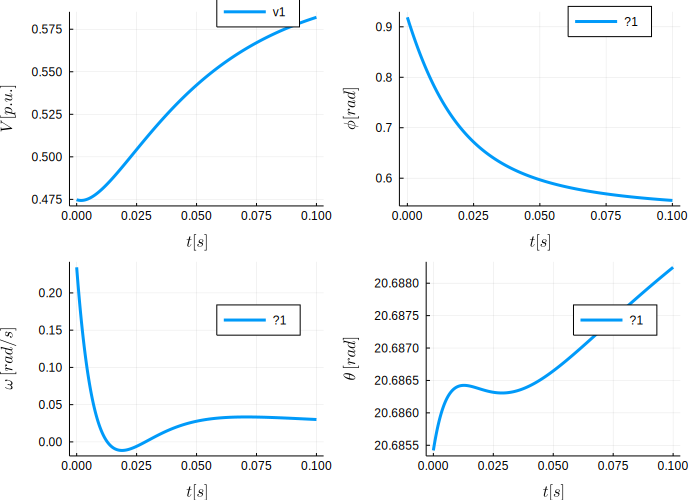

In [284]:
pl_v = plot(sol, 1, :v, legend = (0.8, 1.), ylabel=L"V [p.u.]")
pl_p = plot(sol, 1, :φ, legend = (0.8, 0.95), ylabel=L"\phi [rad]")
pl_ω = plot(sol, 1, :ω, legend = (0.8, 0.7), ylabel=L"\omega \left[rad/s\right]")
pl_θ = plot(sol, 1, :θ, legend = (0.8, 0.7), ylabel=L"\theta \left[rad\right]")
pl = plot(
    pl_v, pl_p, pl_ω, pl_θ;
    layout=(2,2),
    size = (700, 500),
    lw=3,
    xlabel=L"t[s]"
)

In [278]:
sol(timespan[2], 1:1, :ω)

1-element Array{Float64,1}:
 0.23462805990033975

In [280]:
x0 = operationpoint(g, randn(rng, SystemSize(g))) # just to create the right type for x0
for i in 1:SystemSize(g)
    x0.base.vec[i] = sol.dqsol[i, end]
end

In [281]:
timespan = (0.0, 100.)
sol = solve(g, x0, timespan);

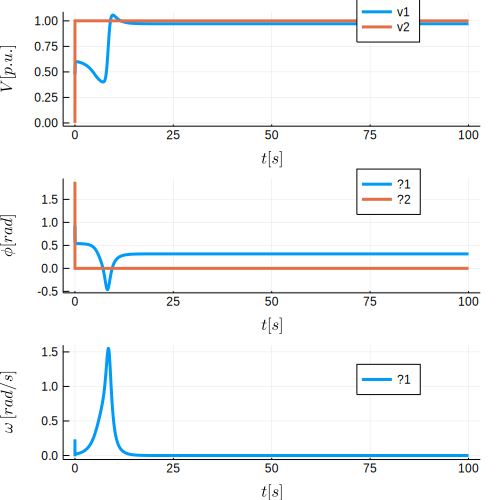

In [282]:
pl_v = plot(sol, :, :v, legend = (0.8, 1.), ylabel=L"V [p.u.]")
pl_p = plot(sol, :, :φ, legend = (0.8, 0.95), ylabel=L"\phi [rad]")
pl_ω = plot(sol, 1, :ω, legend = (0.8, 0.7), ylabel=L"\omega \left[rad/s\right]")
pl = plot(
    pl_v, pl_p, pl_ω;
    layout=(3,1),
    size = (500, 500),
    lw=3,
    xlabel=L"t[s]"
)